In [1]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import keras_utils
import numpy as np
import sys
sys.path.append("..")

C:\Users\Banipreet\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [3]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

HBox(children=(IntProgress(value=0, max=18983), HTML(value='')))

In [4]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


1551

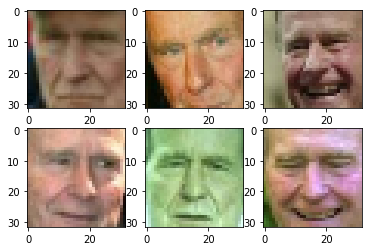

In [5]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

In [6]:
def build_pca_autoencoder(img_shape, code_size):
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

In [7]:
s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)

Epoch 1/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 2/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 3/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 4/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 5/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 6/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 7/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 8/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 9/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 10/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 11/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 12/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 13/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 14/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 15/15


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [8]:
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.006599517984974407


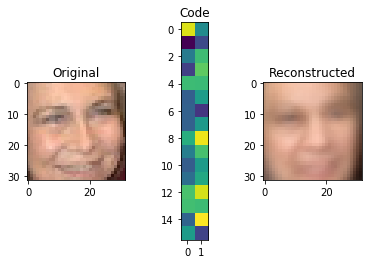

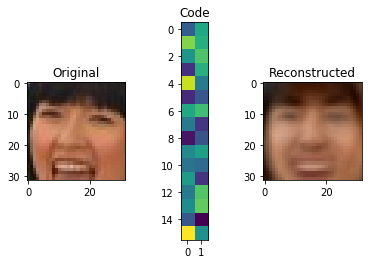

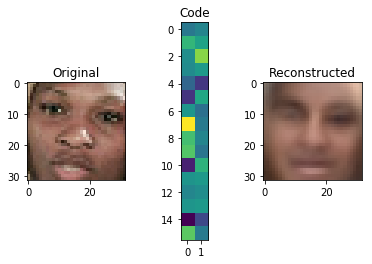

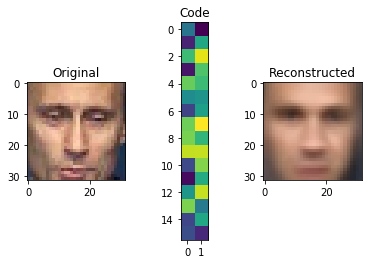

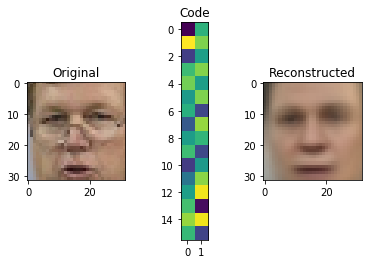

In [9]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [11]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
   
    encoder.add(L.Conv2D(filters=32, kernel_size=(3,3), padding='same'))
    encoder.add(L.Activation('elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(filters=64, kernel_size=(3,3), padding='same'))
    encoder.add(L.Activation('elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(filters=128, kernel_size=(3,3), padding='same'))
    encoder.add(L.Activation('elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(filters=256, kernel_size=(3,3), padding='same'))
    encoder.add(L.Activation('elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))
    
    
    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(2*2*256))
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [12]:
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [13]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [15]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)

Epoch 1/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 2/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 3/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 4/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 5/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 6/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 7/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 8/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 9/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 10/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 11/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 12/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 13/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 14/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 15/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 16/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 17/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 18/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 19/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 20/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 21/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 22/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 23/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 24/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 25/25


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Convolutional autoencoder MSE: 0.0054898707286415785


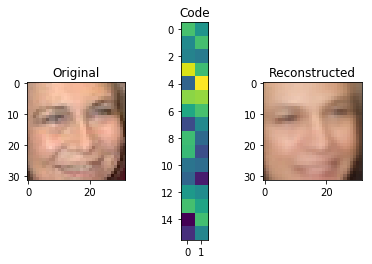

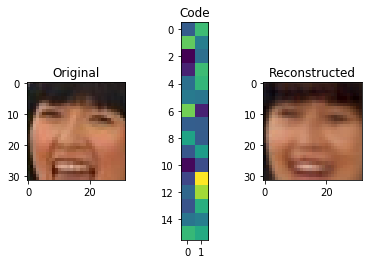

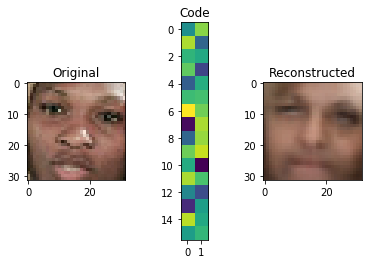

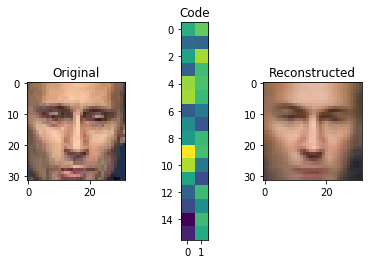

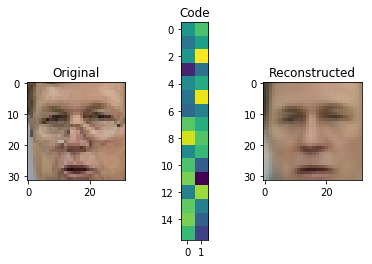

In [16]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [17]:
def apply_gaussian_noise(X,sigma=0.1):
    noise = np.random.normal(scale = sigma, size = X.shape)
    return X + noise

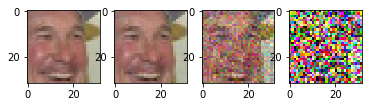

In [18]:
# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [19]:
s = reset_tf_session()

# we use bigger code size here for better quality
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    callbacks=[keras_utils.TqdmProgressCallback()],
                    verbose=0)

Epoch 1/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 2/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 3/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 4/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 5/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 6/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 7/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 8/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 9/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 10/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 11/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 12/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 13/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 14/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 15/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 16/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 17/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 18/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 19/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 20/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 21/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 22/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 23/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 24/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Epoch 25/25, Generating corrupted samples...
Epoch 1/1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Denoising MSE: 0.0027763530063998846


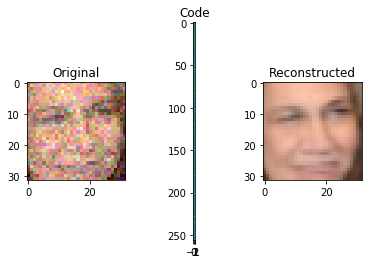

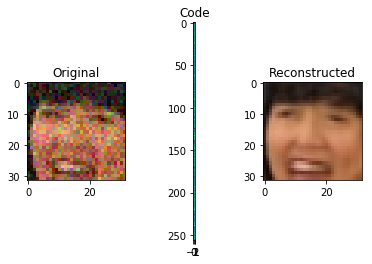

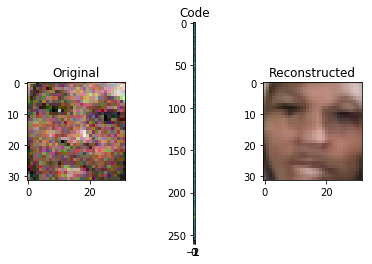

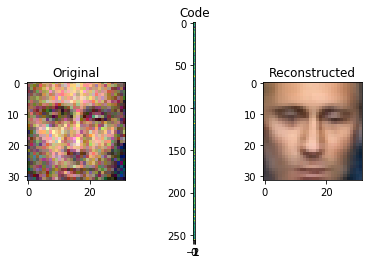

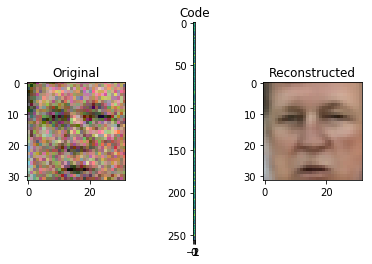

In [20]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)